##Recap: Python Functions

Functions in Python can be used or passed as arguments.

In [1]:
def say_hello(name):
    return f"Hello {name}"

def be_awesome(name):
    return f"Yo {name}, together we are the awesomest!"

def greet_bob(greeter_func):
    return greeter_func("Bob")

In [2]:
greet_bob(say_hello)

'Hello Bob'

In [3]:
greet_bob(be_awesome)

'Yo Bob, together we are the awesomest!'

##Decorators
Functions are taken as the argument into another function and then called inside the wrapper function.

*   Allows programmers to modify the behaviour of a function or class
*   Allow us to wrap another function in order to extend the behaviour of the wrapped function, without permanently modifying it



In [4]:
def my_decorator(func):
    def wrapper():
        print("Something is happening before the function is called.")
        func()
        print("Something is happening after the function is called.")
    return wrapper

def say_whee():
    print("Whee!")

say_whee = my_decorator(say_whee)

In [5]:
say_whee()

Something is happening before the function is called.
Whee!
Something is happening after the function is called.


***Put simply:*** decorators wrap a function, modifying its behavior.

In [6]:
from datetime import datetime

def not_till_noon(func):
    def wrapper():
        if 0 <= datetime.now().hour < 12:
            func()
        else:
            pass
    return wrapper

def say_whee():
    print("Whee!")

say_whee = not_till_noon(say_whee)

In [7]:
say_whee()

##A better way of defining decorators

In [8]:
def my_decorator(func):
    def wrapper():
        print("Something is happening before the function is called.")
        func()
        print("Something is happening after the function is called.")
    return wrapper

@my_decorator
def say_whee():
    print("Whee!")

In [9]:
say_whee()

Something is happening before the function is called.
Whee!
Something is happening after the function is called.


##Decorating Functions With Arguments

In [10]:
def do_twice(func):
    def wrapper_do_twice(*args, **kwargs):
        func(*args, **kwargs)
        func(*args, **kwargs)
    return wrapper_do_twice

In [11]:
@do_twice
def greet(name):
    print(f"Hello {name}")

In [12]:
greet("World")

Hello World
Hello World


##CUDA JIT Decorator

What is CUDA (Compute Unified Device Architecture)?
*   parallel computing platform
*   speed up intensive applications

What is CUDA JIT (Just In Time)?
*   Available in Python ecosystem through Numba
*   A grid is composed of blocks; a block is composed of threads.

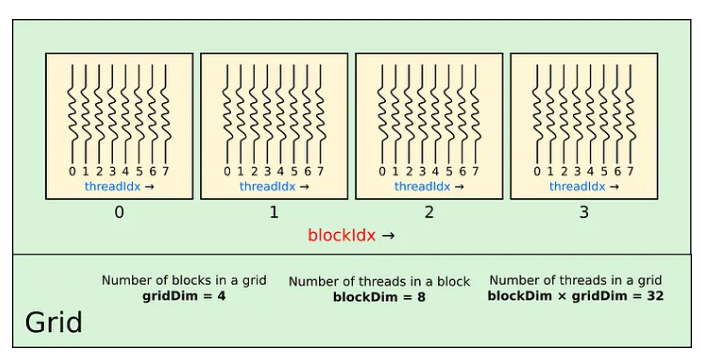

In [13]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

FIND: Invalid switch
FIND: Invalid switch


In [14]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

In [15]:
import numpy as np
import math
from numba import cuda

In [16]:
cuda.detect()

Found 1 CUDA devices
id 0    b'NVIDIA GeForce GTX 1650'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 0
                              PCI Bus ID: 2
                                    UUID: GPU-02c2cb06-1dbc-6ef9-a8c6-48ef486347fb
                                Watchdog: Enabled
                            Compute Mode: WDDM
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

##Example 1: Square each element in matrix

In [17]:
@cuda.jit
def gpu_sqr(out): 
  # get the thread coordinates in 2D
  i1, i2 = cuda.grid(2)
  out[i1][i2] = out[i1][i2]*out[i1][i2]

@cuda.jit
def gpu_add(a, b, out):
  i1, i2 = cuda.grid(2)
  out[i1][i2] = a[i1][i2] + b[i1][i2]

In [18]:
a = np.arange(12).reshape(3,4)
b = np.arange(0,120,10).reshape(3,4)
print(a)
print(b)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[  0  10  20  30]
 [ 40  50  60  70]
 [ 80  90 100 110]]


In [19]:
d_a = cuda.to_device(a)
d_b = cuda.to_device(b)
d_out = cuda.device_array_like(d_a)

# we use two blocks, side-by-side in the horizontal direction
blocks = (1,2)
# each block has 6 threads arranged in 3 lines and 2 columns
threads_per_block = (3,2)
gpu_sqr[blocks, threads_per_block](d_a)
gpu_sqr[blocks, threads_per_block](d_b)

gpu_add[blocks, threads_per_block](d_a, d_b, d_out)

print(d_a.copy_to_host())
print(d_b.copy_to_host())
print(d_out.copy_to_host())

c:\Users\anees\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[[  0   1   4   9]
 [ 16  25  36  49]
 [ 64  81 100 121]]
[[    0   100   400   900]
 [ 1600  2500  3600  4900]
 [ 6400  8100 10000 12100]]
[[    0   101   404   909]
 [ 1616  2525  3636  4949]
 [ 6464  8181 10100 12221]]


c:\Users\anees\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


##Example 2: Matrix Multiplication

In [20]:
from numba import cuda
import cupy as cp
import numpy as np

In [21]:
@cuda.jit
def matmul(A, B, C):
    """Perform square matrix multiplication of C = A * B
    """
    i, j = cuda.grid(2)  
    if i < C.shape[0] and j < C.shape[1]:   
        tmp = 0.                            
        for k in range(A.shape[1]):
            tmp += A[i, k] * B[k, j]       
        C[i, j] = tmp

In [22]:
cp.random.seed(42)
A = cp.random.uniform(1, 10, size=(2000, 2000), dtype=np.float64)  
B = cp.random.uniform(1, 10, size=(2000, 2000), dtype=np.float64)  
C = cp.zeros((2000, 2000), dtype=np.float64)       

In [23]:
threadsperblock = (16, 16)  # each block will contain 16x16 threads, typically 128 - 512 threads/block
blockspergrid_x = int(np.ceil(C.shape[0] / threadsperblock[0]))
blockspergrid_y = int(np.ceil(C.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y) 
print(blockspergrid)
print(f"The kernel will be executed up to element {threadsperblock[0]*blockspergrid_x}")

(125, 125)
The kernel will be executed up to element 2000


In [24]:
matmul[blockspergrid, threadsperblock](A, B, C)

In [25]:
C

array([[59394.46607842, 58001.66377549, 58910.89964126, ...,
        58755.23643036, 59265.65525416, 58447.86197932],
       [59656.82462269, 58635.04995946, 59080.54393462, ...,
        59327.90030958, 60391.24930458, 59425.35827899],
       [62192.77335924, 60700.17680915, 60538.34933653, ...,
        61027.03460329, 61711.10155029, 60544.69882075],
       ...,
       [60649.27416407, 59951.20972379, 60170.2004206 , ...,
        60203.88074659, 60934.19598791, 59613.28418599],
       [61620.11922557, 61264.33868343, 62076.33462258, ...,
        61227.57661876, 62642.97523374, 61841.46799761],
       [61535.95697543, 59600.43760873, 59927.620961  , ...,
        60738.55627077, 61429.70009593, 59662.34901713]])